# Load Dependencies

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem,Descriptors
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from script.descriptor import get_acsf_dict,GetRdkitDescriptorsdict,get_fp_dict,get_oh,des_std
from script.model import  models
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
data_file = '../data2/data2.csv'
mol_dir = '../data2/data2_sdf_files/'
tmp_df = pd.read_csv(data_file)
cat_smiles = np.array(tmp_df['Catalyst'].to_list())
imine_smiles =  np.array(tmp_df['Imine'].to_list())
thiol_smiles =  np.array(tmp_df['Thiol'].to_list())
labels = np.array(tmp_df['Output'].to_list())
labels_std = (labels - labels.min())/(labels.max()-labels.min())
cat_smi_set = list(set(cat_smiles))
imine_smi_set = list(set(imine_smiles))
thiol_smi_set = list(set(thiol_smiles))
cat_smi_set.sort()
imine_smi_set.sort()
thiol_smi_set.sort()

# Generate Descriptor

In [3]:
rdkit_cat_all_dict = GetRdkitDescriptorsdict(cat_smi_set)
rdkit_imine_all_dict= GetRdkitDescriptorsdict(imine_smi_set)
rdkit_thiol_all_dict =GetRdkitDescriptorsdict(thiol_smi_set)

fp_cat_all_dict = get_fp_dict(cat_smi_set)
fp_imine_all_dict= get_fp_dict(imine_smi_set)
fp_thiol_all_dict =get_fp_dict(thiol_smi_set)

species=['N', 'H', 'C', 'P',"F","Cl","Br","O","I","S","Si"]
acsf_cat_all_dict = get_acsf_dict(cat_smi_set,species=species)
acsf_imine_all_dict= get_acsf_dict(imine_smi_set,species=species)
acsf_thiol_all_dict =get_acsf_dict(thiol_smi_set,species=species)

cat_oh_desc=get_oh(cat_smiles)
imine_oh_desc=get_oh(imine_smiles)
thiol_oh_desc=get_oh(thiol_smiles)

[19:36:46] UFFTYPER: Unrecognized atom type: S_6+6 (10)
RDKit ERROR: [19:36:46] UFFTYPER: Unrecognized atom type: S_6+6 (10)
RDKit ERROR: [19:36:46] UFFTYPER: Unrecognized atom type: S_6+6 (34)
[19:36:46] UFFTYPER: Unrecognized atom type: S_6+6 (34)
RDKit ERROR: [19:37:09] UFFTYPER: Unrecognized atom type: S_6+6 (10)
[19:37:09] UFFTYPER: Unrecognized atom type: S_6+6 (10)
RDKit ERROR: [19:37:09] UFFTYPER: Unrecognized atom type: S_6+6 (34)
[19:37:09] UFFTYPER: Unrecognized atom type: S_6+6 (34)
RDKit ERROR: [19:37:09] UFFTYPER: Unrecognized atom type: S_6+6 (10)
[19:37:09] UFFTYPER: Unrecognized atom type: S_6+6 (10)
RDKit ERROR: [19:37:09] UFFTYPER: Unrecognized atom type: S_6+6 (34)
[19:37:09] UFFTYPER: Unrecognized atom type: S_6+6 (34)


# Generate Reaction Feature

In [4]:
all_number=1075
acsf_total_cat = np.array([[acsf_cat_all_dict[tmp_smi]] for tmp_smi in cat_smiles]).reshape(all_number,-1)
acsf_total_imine = np.array([[acsf_imine_all_dict[tmp_smi]] for tmp_smi in imine_smiles]).reshape(all_number,-1)
acsf_total_thiol = np.array([[acsf_thiol_all_dict[tmp_smi]] for tmp_smi in thiol_smiles]).reshape(all_number,-1)
acsf_react_feat = np.concatenate([acsf_total_cat,acsf_total_imine,acsf_total_thiol],axis = 1)
acsf_react_feat_std=des_std(acsf_react_feat)

rdkit_total_cat = np.array([[rdkit_cat_all_dict[tmp_smi]] for tmp_smi in cat_smiles]).reshape(all_number,-1)
rdkit_total_imine = np.array([[rdkit_imine_all_dict[tmp_smi]] for tmp_smi in imine_smiles]).reshape(all_number,-1)
rdkit_total_thiol = np.array([[rdkit_thiol_all_dict[tmp_smi]] for tmp_smi in thiol_smiles]).reshape(all_number,-1)
rdkit_react_feat = np.concatenate([rdkit_total_cat,rdkit_total_imine,rdkit_total_thiol],axis = 1)
rdkit_react_feat_std=des_std(rdkit_react_feat)

fp_total_cat = np.array([[fp_cat_all_dict[tmp_smi]] for tmp_smi in cat_smiles]).reshape(all_number,-1)
fp_total_imine = np.array([[fp_imine_all_dict[tmp_smi]] for tmp_smi in imine_smiles]).reshape(all_number,-1)
fp_total_thiol = np.array([[fp_thiol_all_dict[tmp_smi]] for tmp_smi in thiol_smiles]).reshape(all_number,-1)
fp_react_feat = np.concatenate([fp_total_cat,fp_total_imine,fp_total_thiol],axis = 1)
fp_react_feat_std=des_std(fp_react_feat)

oh_react_feat = np.concatenate([cat_oh_desc,imine_oh_desc,thiol_oh_desc],axis = 1)
oh_react_feat_std=des_std(oh_react_feat)
descs = [oh_react_feat_std,rdkit_react_feat_std,fp_react_feat_std,acsf_react_feat_std]
model_names = ['Ada','BG','DT','ET','GB','KNR','KRR','LSVR','RF','Ridge','SVR','XGB','NN']
desc_names = ['OH','Rdkit','MF','ACSFs']

In [5]:
np.save('./data/data2_oh_react_feat_std.npy',oh_react_feat_std)
np.save('./data/data2_rdkit_react_feat_std.npy',rdkit_react_feat_std)
np.save('./data/data2_fp_react_feat_std.npy',fp_react_feat_std)
np.save('./data/data2_acsf_react_feat_std.npy',acsf_react_feat_std)

# Tain Model

In [6]:
np.random.seed(1000)
shuffle = np.array(list(range(1075)))
np.random.shuffle(shuffle)
train_index = shuffle[:600]
val_index = shuffle[600:]

In [7]:
performance_dict = {}
for model,model_name in zip(models,model_names):
    for desc,desc_name in zip(descs,desc_names): 
        all_r2 = []
        all_pearsr = []
        all_mae = []
        all_rmse= []
        repeat_pred = []
        repeat_test = []
        for i in range(10):           
            train_x,test_x = desc[train_index],desc[val_index]
            train_y,test_y = labels_std[train_index],labels_std[val_index]
            model.fit(train_x,train_y)
            test_pred = model.predict(test_x)*(labels.max()-labels.min())+labels.min()
            test_y=test_y*(labels.max()-labels.min())+labels.min()
            repeat_pred.append(test_pred)
            repeat_test.append(test_y)
            r2 = r2_score(test_y,test_pred)
            pearsr = pearsonr(test_y,test_pred)
            mae = mean_absolute_error(test_y,test_pred)
            rmse=(mean_squared_error(test_y,test_pred))**(0.5)
            all_r2.append(r2)
            all_pearsr.append(pearsr[0])
            all_mae.append(mae)
            all_rmse.append(rmse)
        performance_dict['%s-%s'%(model_name,desc_name)] = [np.mean(all_r2),np.mean(all_pearsr),np.mean(all_mae),
                                                            np.mean(all_rmse),repeat_pred[np.argmax(all_r2)],repeat_test[np.argmax(all_r2)]]
        print('Model: %5s, Descriptor: %15s: R2: %.4f, MAE: %.4f, RMSE: %.4f, Pearson R: %.4f'%(
        model_name,desc_name,np.mean(all_r2),np.mean(all_mae),np.mean(all_rmse),np.mean(all_pearsr)))

Model:   Ada, Descriptor:              OH: R2: 0.8603, MAE: 0.1708, RMSE: 0.2565, Pearson R: 0.9331
Model:   Ada, Descriptor:           Rdkit: R2: 0.8879, MAE: 0.1549, RMSE: 0.2301, Pearson R: 0.9450
Model:   Ada, Descriptor:              MF: R2: 0.8706, MAE: 0.1640, RMSE: 0.2472, Pearson R: 0.9378
Model:   Ada, Descriptor:           ACSFs: R2: 0.8610, MAE: 0.1733, RMSE: 0.2563, Pearson R: 0.9323
Model:    BG, Descriptor:              OH: R2: 0.7736, MAE: 0.2482, RMSE: 0.3270, Pearson R: 0.8988
Model:    BG, Descriptor:           Rdkit: R2: 0.8883, MAE: 0.1690, RMSE: 0.2297, Pearson R: 0.9436
Model:    BG, Descriptor:              MF: R2: 0.8784, MAE: 0.1726, RMSE: 0.2397, Pearson R: 0.9374
Model:    BG, Descriptor:           ACSFs: R2: 0.8583, MAE: 0.1900, RMSE: 0.2588, Pearson R: 0.9332
Model:    DT, Descriptor:              OH: R2: 0.8316, MAE: 0.1918, RMSE: 0.2821, Pearson R: 0.9220
Model:    DT, Descriptor:           Rdkit: R2: 0.7987, MAE: 0.1997, RMSE: 0.3084, Pearson R: 0.9067


# Results of Models

<AxesSubplot:>

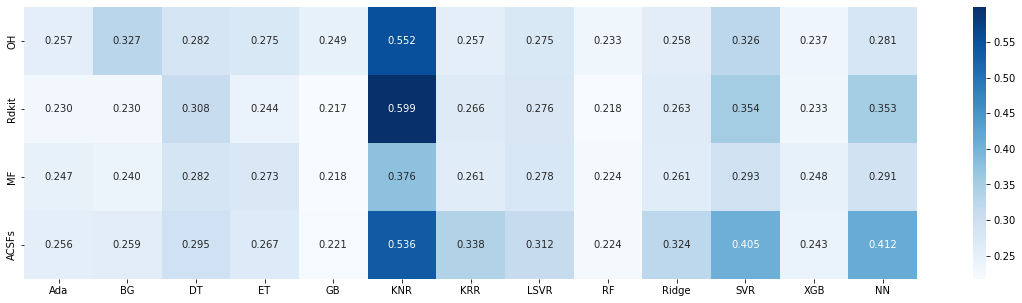

In [8]:
r2_map = np.zeros((len(desc_names),len(model_names)))
for i,m in enumerate(model_names):
    for j,d in enumerate(desc_names):
        r2_map[j,i] = performance_dict['%s-%s'%(m,d)][3]

fig = plt.figure(figsize=(20,5))
sns.heatmap((r2_map),annot=True,fmt='.3f',xticklabels=model_names,yticklabels=desc_names,cmap='Blues')

In [9]:
np.save('./data/data2_cus_result10.npy',performance_dict)